# Importing requirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

m,n,q = 640,256,113
def generate_e(sigma,size=m):
    return np.random.normal(0,sigma,size=size).reshape(-1,1).astype(int)

generate_b = lambda sig: (A@S + generate_e(sig)) % q
accuracy = lambda x,y: (x==y).sum()/len(y)*100
print_minmax = lambda b: print(f"min: {b.min()}\nmax: {b.max()}")

def initialize_expt(m=m,n=n,q=q,sigma_factor=0.05,seed=69,verbose=1):

    sigma = sigma_factor*q
    np.random.seed(seed)
    A = np.round(np.random.rand(m,n)).astype(int)
    S = np.round(np.random.rand(n,1)).astype(int)

    e = generate_e(sigma)

    b = (A@S + e) % q
    if verbose:
        print("Initialized LWE instance.")
        print("Range of b:")
        print_minmax(b)

    return A,S,e,b,sigma

<a class="anchor" id="index"></a>
## Jump to section:
1. [Exploration](#exploration)
2. [Scoring based method](#scoring)
3. [Using $Ax_i$=$u_i$](#methodaxu)
4. [Encryption using LWE](#encryption)

<a class="anchor" id="exploration"></a>
# Exploration

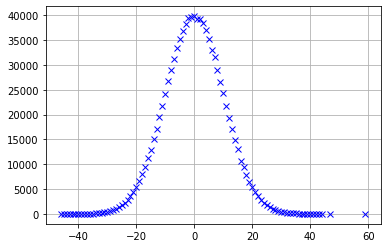

In [8]:
k = np.random.normal(0,10,size=1000000)

def plot_distribution(k):
    k = np.round(k).reshape(-1,)
    plt.plot(Counter(k).keys(),Counter(k).values(),"bx")
    plt.grid()
    
plot_distribution(k)

In [9]:
m = 640
n = 256
q = 113
sigma = 1/n*q
seed = 69

np.random.seed(seed)
A = np.round(np.random.rand(m,n)).astype(int)
S = np.round(np.random.rand(n,1)).astype(int)

generate_e = lambda sig: np.round(np.random.normal(0,sig,size=m).reshape(m,1)).astype(int)
e = generate_e(sigma)

b = (A@S % q + e % q) % q

In [10]:
print(f"min: {b.min()}\nmax: {b.max()}")

min: 48
max: 77


In [ ]:
lstsq_sol = np.linalg.lstsq(A,b,rcond=0)[0]
plot_distribution(lstsq_sol)

In [18]:
thresh = 0.5
lstsq_sol[lstsq_sol>thresh]=1
lstsq_sol[lstsq_sol<thresh]=0

In [19]:
accuracy = lambda x,y: (x==y).sum()/len(y)*100
accuracy(lstsq_sol,S)

100.0

In [11]:
try:
    atainv = np.linalg.inv(A.T@A)
    pred_knownE = np.round(atainv@A.T@(b-e)).astype(int)
    pred_unknownE = np.round(atainv@A.T@(b-generate_e(sigma))).astype(int)
    print(accuracy(pred_knownE,S),accuracy(pred_unknownE,S),sep='\n')
except np.linalg.LinAlgError:
    print("A.T@A is not invertible")

100.0
46.875


<a class="anchor" id="scoring"></a>
# Testing a scoring based method 

In [31]:
A,S,e,b,sigma = initialize_expt(sigma_factor=1/n)

Initialized LWE instance.
Range of b:
min: 48
max: 77


In [31]:
def run(num_iter=100,update_interval=10,q=q,sigma_factor=0.05,seed=50,plot=True,verbose=1):
    A,S,e,b,sigma = initialize_expt(q=q,sigma_factor=sigma_factor,seed=seed,verbose=verbose)
    if verbose: 
        print("Range of e:")
        print_minmax(e)

    scores = np.zeros((A.shape[1],2))
    acc = []

    pbar = tqdm(range(num_iter),ncols=100) if verbose else range(num_iter)
    for i in pbar:
        b_ = (b - generate_e(sigma)) % q
        sol = np.linalg.lstsq(A,b_,rcond=0)[0]

        thresh = sol.mean()
        sol[sol>thresh] = 1
        sol[sol<thresh] = 0

        for n,s in enumerate(sol):
            scores[n][int(s)] += 1

        if i % update_interval == 0:
            temp_sol = np.argmax(scores,axis=1).reshape(-1,1)
            acc.append([i,accuracy(temp_sol,S)])
        
    if plot:
        plt.figure(figsize=(7,5))
        plt.plot(acc);plt.plot(acc,'bo')
        plt.title("Accuracy vs iterations")
        plt.xlabel("Iteration");plt.ylabel("Accuracy")
        plt.show()

    return np.array(acc)

In [32]:
sigmas = np.linspace(1/n,0.05,5)
accs = [run(sigma_factor=s,plot=False,verbose=0) for s in tqdm(sigmas,ncols=100)]

100%|█████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.96s/it]


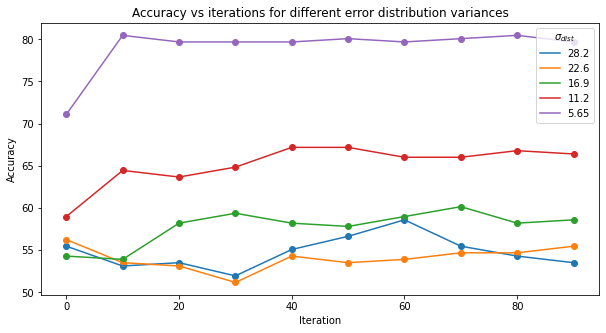

In [43]:
plt.figure(figsize=(10,5))
for n,acc in enumerate(accs):
    plt.plot(acc[:,0],acc[:,1],label=str(sigmas[n]*q)[:4]);plt.scatter(acc[:,0],acc[:,1])
    plt.title("Accuracy vs iterations for different error distribution variances")
    plt.xlabel("Iteration");plt.ylabel("Accuracy")
    plt.legend(title=r"$\sigma_{dist}$")
plt.show()

* For lower errors, least squares is a reasonable approximation

<a class="anchor" id="methodaxu"></a>
# Method 2:
## Finding $x_i$'s such that $Ax_i = u_i$

An attacker can take the transpose of $b$, giving $b^T$, and multiply by $x_i's$ to get the corresponding bit value of s

$$
\begin{align*}
b &= A \times S + e \\
b^T &= S^T \times A^T + e^T \\
b^T \times x_i &= S^T \times u_i + e^T \times x_i \\
b^T \times x_i &= S^T_i + e^T \times x_i \\
\end{align*}
$$

The attacker knows $b^T$, hopes the norm of $x_i$ is small enough, and then approximates the bit $S^T_i$ using the output 

In [3]:
A,S,e,b,sigma = initialize_expt()

Initialized LWE instance.
Range of b:
min: 34
max: 82


In [214]:
U = np.eye(n)
norms = []
enorms = []

X = np.linalg.lstsq(A.T,U,rcond=0)[0].T
for i in range(len(U)):
    norms.append(np.linalg.norm(X[i]))
    enorms.append((e.T@X[i])[0])    
print(f"Maximum norms :\t x_{np.argmax(norms)+1} = {max(norms):.4f}\te.T@x_{np.argmax(enorms)+1} = {max(enorms):.4f}")

Maximum norms :	 x_89 = 0.1088	e.T@x_28 = 1.6765


In [216]:
def run_axu(sigma_factor=0.05,seed=None):
    if seed is not None: np.random.seed(seed)
    A,S,e,b,sigma = initialize_expt(sigma_factor=sigma_factor,seed=np.random.randint(0,1e5),verbose=0)
    
    U = np.eye(n)
    X = np.linalg.lstsq(A.T,U,rcond=0)[0]
   
    preds = np.round((b.T@X).reshape(-1,1))
    acc = accuracy(preds,S)
    return acc

In [220]:
sigmas = np.linspace(1/n,0.05,100)

res = []
for sigma in tqdm(sigmas,ncols=100):
    iter = []
    for i in range(20):
        iter.append(run_axu(sigma_factor=sigma))
    res.append([sigma,np.mean(iter)])

res = np.array(res)
np.save("../results/axu_varsigma.npy",res)

100%|█████████████████████████████████████████████████████████████| 100/100 [11:43<00:00,  7.04s/it]


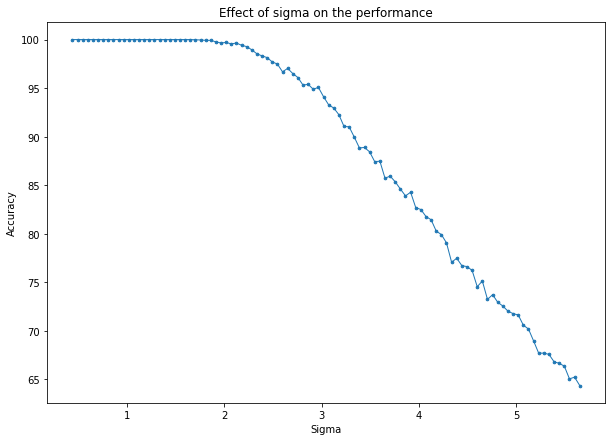

In [230]:
res = np.load("../results/axu_varsigma.npy")
plt.figure(figsize=(10,7))
plt.plot(res[:,0]*q,res[:,1],linewidth=1);plt.scatter(res[:,0]*q,res[:,1],s=7)    
plt.title("Effect of sigma on the performance")
plt.xlabel("Sigma");plt.ylabel("Accuracy")
plt.show()

## Experimenting with $x_i$'s such that $Ax_i = u_i+u_{i+1}$
The equations we will get are:
$$
S^T_i + S^T_{i+1} = b^T \times x_i
$$
Therefore, if we know S^T_0, the first bit of S, we can successively subtract and round off to get the next bits of S

100%|███████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]


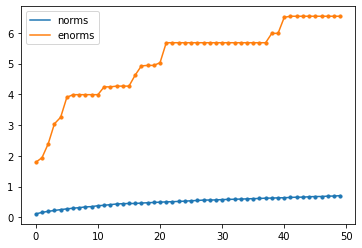

In [4]:
U = np.eye(n)
norms = []
enorms = []

def stagger_and_add(mat,stagger=1):
    mat_orig = mat.copy()
    for i in range(1,stagger+1):
        mat = np.vstack((mat_orig[i:],mat_orig[0:i])) + mat
    return mat

stagger_ls = [i for i in range(50)]

maxnorms = np.zeros((len(stagger_ls),2))
maxenorms = np.zeros((len(stagger_ls),2))
for ii,st in enumerate(tqdm(stagger_ls,ncols=100)):
    X = np.linalg.lstsq(A.T,stagger_and_add(U,st),rcond=0)[0].T
    for i in range(len(U)):
        norms.append(np.linalg.norm(X[i]))
        enorms.append((e.T@X[i])[0])
    maxnorms[ii] = (st,max(norms))
    maxenorms[ii] = (st,max(np.abs(enorms)))
    
    # print(f"Maximum norms :\t x_{np.argmax(norms)+1} = {max(norms):.4f}\te.T@x_{np.argmax(enorms)+1} = {max(enorms):.4f}")

plt.plot(maxnorms[:,0],maxnorms[:,1],label="norms")
plt.scatter(maxnorms[:,0],maxnorms[:,1],s=10)
plt.plot(maxenorms[:,0],maxenorms[:,1],label="enorms")
plt.scatter(maxenorms[:,0],maxenorms[:,1],s=10)
plt.legend();plt.show()

In [207]:
from sklearn.preprocessing import MinMaxScaler

def run_axu_stagger(sigma_factor=0.05,stagger=1):
    A,S,e,b,sigma = initialize_expt(sigma_factor=sigma_factor,seed=np.random.randint(0,1e5),verbose=0)
    
    U = np.eye(n)

    X = np.linalg.lstsq(A.T,stagger_and_add(U,stagger),rcond=0)[0]
   
    sums = (b.T@X).reshape(-1,1)

    sums = MinMaxScaler((0,stagger+1)).fit_transform(sums).reshape(-1,)

    preds = list(S[:stagger,0])
    for i in range(len(sums)-1):
        diff = sums[i]-sum(preds[i:stagger])
        dist0 = np.linalg.norm(diff-0)
        dist1 = np.linalg.norm(diff-1)

        pred = 0 if dist0 < dist1 else 1
        preds.append(pred)

    preds = np.array(preds).reshape(-1,1)
    acc = accuracy(preds,S)

    return acc

In [205]:
print("Average success rate:",np.mean([run_axu_stagger(sigma_factor=1/n) for i in range(100)]))

Average success rate: 49.890625


<a class="anchor" id="encryption"></a>
# Encryption using LWE

In [50]:
A,S,e,b,sigma = initialize_expt(q,seed=69)

min: 43
max: 85


In [335]:
def encrypt_using_lwe(M,A,S,sigma,q,seed=None):
    if seed is not None: np.random.seed(seed)

    r = np.round(np.random.rand(A.shape[0])).reshape(1,-1)/10
    e = generate_e(sigma)
    c0 = r@A % q
    c1 = r @ (A@S+e) + (M * np.round(q/2))
    c1 = c1 % q

    # print(r@A@S,r@e,abs(r@e+M*np.round(q/2)),abs(c1-c0@S%q))

    return c0, c1

def decryt_lwe(c0,c1,A,S,b,q):
    Mdash = abs(c1 - c0@S % q)
    return int((abs(Mdash) > abs(np.ceil(q/2)-Mdash)) and (abs(Mdash-q) > abs(np.ceil(q/2)-Mdash)))

In [336]:
def encrypt_decrypt_cycle(M,A,S,b,q,iter=10000):
    outputs = []
    for M_ in M:
        c0, c1 = encrypt_using_lwe(M_,A,S,sigma,q)
        Mdash = decryt_lwe(c0,c1,A,S,b,q)
        outputs.append(Mdash==M_)
        if Mdash != M_:
            print(c1-c0@S, c1-c0@S%q, (c1-c0@S)%q)

    return 100*np.sum(outputs)/len(outputs)

In [446]:
encrypt_decrypt_cycle(np.round(np.random.rand(10)),A,S,b,q)

100.0